# Lab09 - Language Model for Story Writing

In this lab, your task is to build a character-level language model with Transformer. We will train a BPE tokenizer and implement a transformer network in PyTorch. By the end of this lab, you'll understand transformer architecture, subword tokenization, and how to generate text with your trained model.

## Outline
1. [Section 1: Load the dataset](#Section-1:-Load-the-dataset)
2. [Section 2: Training a BPE Tokenizer](#Section-2:-Training-a-BPE-Tokenizer)
3. [Section 3: Custom dataset for Teacher Forcing](#Section-3:-Custom-dataset-for-Teacher-Forcing)
4. [Section 4: Language Model Modeling with Transformer](#Section-4:-Language-Model-Modeling-with-Transformer)
   1. [Positional Encoding](#4.1-Positional-Encoding)
   2. [Language Modeling with Encoder-Only Transformer](#4.2-Language-Modeling-with-Encoder-Only-Transformer)
   3. [Define the Mask](#4.3-Define-the-mask)
   4. [Train the Language Model](#4.4-Train-the-Language-Model)
   5. [Generating novel text](#4.5-Generating-novel-text)

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import math, time


# import library here
# ...

In [2]:
torch.manual_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
print('Device =', DEVICE)

Device = cuda


---
# Section 1: Load the dataset

The model is trained on the [Children Stories Text Corpus](https://www.kaggle.com/datasets/edenbd/children-stories-text-corpus) in Kaggle. The dataset consists of public domain children's books from Project[Gutenberg](https://www.gutenberg.org/) that are suitable for young readers. These books are hand-picked and cleaned before use (e.g., removed metadata, offensive language, and illustrations).

In [3]:
import kagglehub

path = kagglehub.dataset_download("edenbd/children-stories-text-corpus")

print("Path to dataset files:", path)
print('Files in path:', os.listdir(path))

Path to dataset files: /kaggle/input/children-stories-text-corpus
Files in path: ['cleaned_merged_fairy_tales_without_eos.txt']


Read the dataset into the string `raw_data`.

In [4]:
dataset_path = os.path.join(path, 'cleaned_merged_fairy_tales_without_eos.txt')
with open(dataset_path, 'r') as f:
    raw_data = f.read()

print(f'Number of characters in dataset = {len(raw_data):}')

# print the first 300 characters
print('---------------------')
print(raw_data[:1000])

Number of characters in dataset = 20455694
---------------------
The Happy Prince.
HIGH above the city, on a tall column, stood the statue of the Happy Prince.  He was gilded all over with thin leaves of fine gold, for eyes he had two bright sapphires, and a large red ruby glowed on his sword-hilt.
He was very much admired indeed.  “He is as beautiful as a weathercock,” remarked one of the Town Councillors who wished to gain a reputation for having artistic tastes; “only not quite so useful,” he added, fearing lest people should think him unpractical, which he really was not.
“Why can’t you be like the Happy Prince?” asked a sensible mother of her little boy who was crying for the moon.  “The Happy Prince never dreams of crying for anything.”
“I am glad there is some one in the world who is quite happy,” muttered a disappointed man as he gazed at the wonderful statue.
“He looks just like an angel,” said the Charity Children as they came out of the cathedral in their bright scarlet cloa

---
# Section 2: Training a BPE Tokenizer

This creates a [Tokenizer](https://huggingface.co/docs/tokenizers/en/api/tokenizer#tokenizers.Tokenizer) using the [BPE](https://huggingface.co/docs/tokenizers/en/api/models#tokenizers.models.BPE) (Byte Pair Encoding) algorithm.

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

In [6]:
bpe = BPE()
tokenizer = Tokenizer(bpe)

print(tokenizer)

Tokenizer(version="1.0", truncation=None, padding=None, added_tokens=[], normalizer=None, pre_tokenizer=None, post_processor=None, decoder=None, model=BPE(dropout=None, unk_token=None, continuing_subword_prefix=None, end_of_word_suffix=None, fuse_unk=False, byte_fallback=False, ignore_merges=False, vocab={}, merges=[]))


Currently the BPE is still untrained and the vocabulary is still empty.

In [7]:
vocab = tokenizer.get_vocab()
print('Vocabulary =', vocab.items())
print('vocab_size =', len(vocab))

Vocabulary = dict_items([])
vocab_size = 0


In this lab, we shall use a **Byte-level BPE (BBPE)** (instead of the traditional BPE) tokenization.

**Pre-tokenizer**. First, set the [pre-tokenizer](https://huggingface.co/docs/tokenizers/en/api/pre-tokenizers) which is reponsible for breaking input text into small chunks before tokenization. Tokenization on text chunks improves efficiency and prevents tokenization across word boundaries. Options:
1. [Whitespace](https://huggingface.co/docs/tokenizers/en/api/pre-tokenizers#tokenizers.pre_tokenizers.Whitespace): Splits text on all whitespace characters (spaces, tabs, line breaks), but does not separate punctuation. Example: `"Hello world!\tHow are you?" → ['Hello', 'world!', 'How', 'are', 'you?']`
2. [ByteLevel](https://huggingface.co/docs/tokenizers/en/api/decoders#tokenizers.decoders.ByteLevel):  Splits text into word-level units while marking leading spaces with a special symbol (`Ġ`). Example: `"Hello world!" → ['Hello', 'Ġworld!']`
   * Used in GPT-2 and RoBERTa.
   * During pre-tokenization, the input is split into chunks of words. Spaces are replaced with `Ġ` and newlines with `Ċ` to make them visible and recoverable.
   * After pre-tokenization, each character is encoded into UTF-8 bytes.
   * During training, BBPE merges on byte pairs (not characters).
   * Since every unicode character (e.g., `é`, `ç`, `漢`, 🍕) has a stable UTF-8 byte representation, this ensures no `[UNK]` tokens even for emojis or rare scripts. This allows exact byte-level reconstruction of the original text.
3. [Metaspace](https://huggingface.co/docs/tokenizers/en/api/pre-tokenizers#tokenizers.pre_tokenizers.Metaspace): Replaces space characters with a visible placeholder (`▁`, `U+2581`) to make whitespace explicit in tokens. Example: `"Hello world" → ['▁Hello', '▁world']`
    * Designed for compatibility with SentencePiece-style tokenizers
    * Used in T5, ALBERT, etc.
    * Helps models distinguish between "world" and " world" by encoding space as a visible symbol.
    * Unlike `ByteLevel`, it operates on **character-level** input and is often used with character or unigram-based models.

**Decoder**. Then, define the the decoder that tells the tokenizer how to convert tokens back into readable text. [ByteLevelDecoder](https://huggingface.co/docs/transformers.js/en/api/tokenizers#module_tokenizers..ByteLevelDecoder) stitches back bytes correctly into a readable string, which allows it to handle spaces and newlines properly. 
|Pre-tokenizer| Common Decoders| Purpose |
|:---:|:---:|:---|
|`Whitespace`| `Sequence`| Reconstruct with spaces |
|`ByteLevel`|`ByteLevel`| Decodes bytes back to original text (byte-perfect) |
|`Metaspace`|`Metaspace` |Replace `_` with spaces|

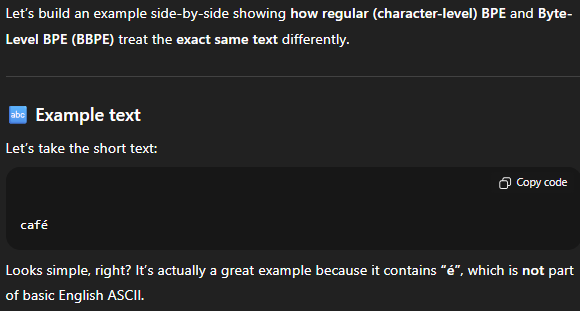
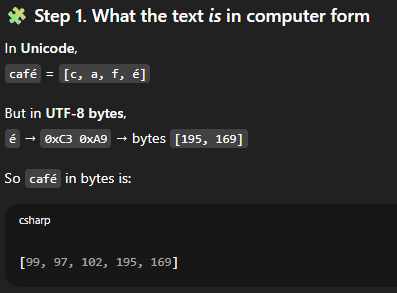
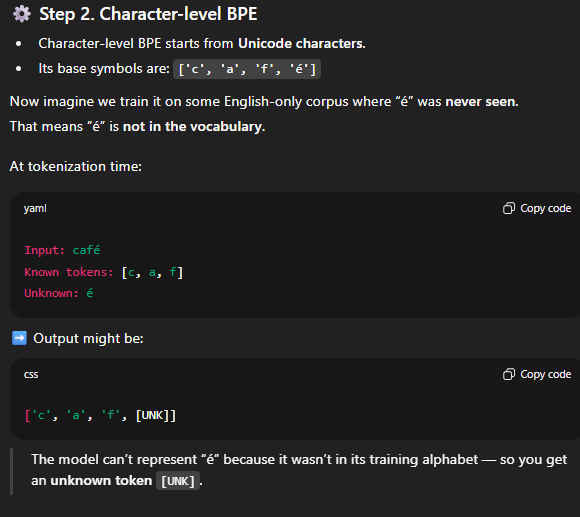
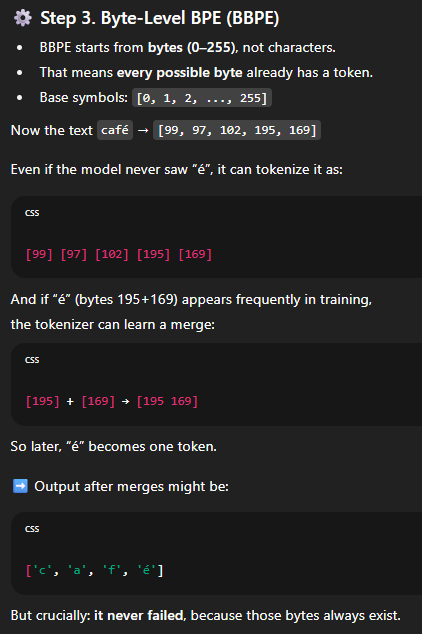

In [8]:
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder

tokenizer.pre_tokenizer = ByteLevel()
tokenizer.decoder = ByteLevelDecoder()

Define [BpeTrainer](https://huggingface.co/docs/tokenizers/en/api/trainers#tokenizers.trainers.BpeTrainer) as the trainer. When defining the trainer, you should also specify the special tokens. 
* `[UNK]`: unknown token
* `[PAD]`: padding
* `[MASK]`: masked language modeling
* `[CLS]`: classification token (classification task)
* `[SEP]`: separator

Train the tokenizer. It will learn how to split and merge characters and words based on BPE algorithm, buidling a vocabulary of 5000 tokens.

In [9]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(vocab_size=5000)
tokenizer.train_from_iterator([raw_data], trainer=trainer) # input list of strings

In [10]:
vocab_size = tokenizer.get_vocab_size()
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 5000


In [11]:
vocab = tokenizer.get_vocab()
print(vocab)

{'Ġdanger': 2066, 'en': 146, 'ken': 1219, 'Ġrepeated': 2868, 'Ġbr': 382, 'LD': 2212, 'Ġwhatever': 2299, 'Ġbegged': 2433, 'Ġjoined': 4253, 'Ġwra': 3945, 'while': 3585, 'ael': 4290, 'Ġcreatures': 3143, 'Ġarri': 1620, 'ĠSunday': 4441, 'Ġknew': 756, 'Ġground': 1169, 'Ġservants': 2624, 'known': 3578, 'orm': 2503, 'Ġwrong': 2281, 'Ġfield': 1647, 'Ġsurface': 3902, 'ĠJohnny': 4367, 'Ġnews': 2532, 'Ġflung': 4200, 'Ġparticularly': 3763, 'Ġpity': 2656, 'N': 40, 'Ġwandered': 4418, 'Ġnumber': 2588, 'iss': 709, 'iew': 2250, 'itary': 3649, 'ĠToto': 4711, 'Ġhills': 3646, 'Ġinterested': 3810, 'Ġbetween': 1278, 'ĠCarton': 4364, 'Ġconsented': 4967, 'Ġcla': 4908, 'Ġsettled': 2881, 'Ġrunning': 1928, 'ipp': 1895, 'Ġpleasant': 2135, 'ast': 281, 'ection': 1915, 'Ġattract': 4084, 'Ġserve': 4876, 'Ġimag': 1817, 'oved': 3970, 'Ġfur': 1461, 'ession': 2925, 'ĠJo': 645, 'Ġsty': 4872, 'Ġstol': 4826, 'Ġbegun': 3379, 'ĠMy': 1712, 'Ġsang': 2820, 'mus': 4774, 'Ġimpat': 3574, 'as': 150, 'rench': 2884, 'Ġcountenance': 488

In the following, we use the tokenizer to encode a sentence using [Tokenizer.encode](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode). The encoded text contsins two items:
1. `.tokens`: a list of subword tokens
2. `.ids`: a list of token IDs


In [12]:
input_text = "First, you know Caius Marcius is chief enemy to the people."

encoded = tokenizer.encode(input_text)
print("Encoded input: ", encoded)
print("Encoded ids input: ", encoded.ids)
print("Encoded input tokens: ", encoded.tokens)

Encoded input:  Encoding(num_tokens=18, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoded ids input:  [413, 571, 9, 176, 416, 329, 3307, 303, 874, 1132, 303, 234, 2648, 3182, 142, 124, 686, 11]
Encoded input tokens:  ['ĠF', 'irst', ',', 'Ġyou', 'Ġknow', 'ĠC', 'ai', 'us', 'ĠMar', 'ci', 'us', 'Ġis', 'Ġchief', 'Ġenemy', 'Ġto', 'Ġthe', 'Ġpeople', '.']


We can decode a sequence of token IDs back into text by using [Tokenizer.decode](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.decode).

In [13]:
decoded = tokenizer.decode(encoded.ids)
print(decoded[:500]) 

 First, you know Caius Marcius is chief enemy to the people.


When we generate the output sequence using a Language model, the tokens are generated token by token. The following show how to print the generated output sequence one token at a time. To avoid printing to a new line, we use the argument `end=''`.

In [14]:
for i in encoded.ids:
    print(tokenizer.decode([i]), end='')

 First, you know Caius Marcius is chief enemy to the people.

In [15]:
import random

encoded_raw_data = tokenizer.encode(raw_data[:1000])

print("Encoded ids input: ", encoded_raw_data.ids)
print("\nEncoded input tokens: ", encoded_raw_data.tokens)

# randomly sample from raw data
start = random.randint(0, 80)
context_length = 10
sample_input = encoded_raw_data.ids[start:start+context_length]
print("\nSample text:")
print(sample_input)

Encoded ids input:  [250, 245, 2578, 1110, 11, 107, 34, 35, 33, 34, 1632, 124, 2167, 9, 181, 123, 2120, 1601, 3977, 9, 828, 124, 198, 140, 509, 154, 124, 245, 2578, 1110, 11, 108, 355, 174, 162, 423, 136, 243, 439, 205, 2710, 2031, 154, 1351, 780, 9, 197, 611, 145, 211, 526, 1353, 200, 256, 63, 2900, 9, 135, 123, 1096, 1140, 3052, 80, 630, 747, 181, 190, 2403, 10, 63, 1643, 11, 107, 628, 174, 360, 517, 1527, 919, 1240, 11, 108, 267, 628, 234, 194, 893, 194, 123, 2840, 634, 215, 381, 3404, 288, 154, 124, 301, 324, 329, 1310, 58, 224, 1035, 299, 1782, 142, 162, 238, 123, 905, 168, 461, 197, 1195, 1416, 392, 306, 2447, 159, 24, 267, 153, 182, 218, 653, 229, 4383, 381, 145, 1841, 9, 347, 1375, 4377, 686, 504, 550, 216, 3758, 1738, 1535, 9, 327, 145, 1093, 174, 218, 11, 107, 202, 1349, 406, 247, 75, 176, 167, 391, 124, 245, 2578, 1110, 463, 635, 123, 2627, 910, 638, 154, 203, 330, 654, 299, 174, 2430, 197, 124, 2115, 11, 108, 267, 210, 245, 2578, 1110, 492, 4680, 154, 2430, 197, 980, 311, 1

---
# Section 3: Custom dataset for Teacher Forcing

To train the model, we use **teacher forcing** where the predicted output is simply the 1-shifted sequence of the input sequence. The length of each sample is the hyperparameter `block_size`. In this lab, we randomly sample a total of `batch_size` samples in each iteration to train the model. Note that the same `block_size` should used during inference when generating novel texts. The trained model is able to handle shorter text but the prediction result will deteriorate if the input sequence is much longer than `block_size`.  

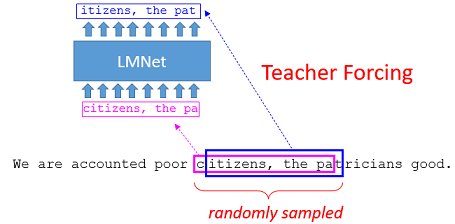

Implement the Custom dataset called `TextDataset` to perform teacher forcing. 

1. `__init__`: opens the text file, prune the text to maximum length upon request, tokenize and encode the text and save the encoded text IDs as `input_ids`.
2. `__len__`: the length of the text is the length of the text - context length - 1. This ensures that the last sample in the dataset also has a length of context length.
3. `__getitem__`:  When indexing the text at position `idx`, the method returns:
    * `x_batch`: the block of text at position `idx` with length `context_length`.
    * `y_batch`: the block of text at position `idx+1` with length `context_length`.


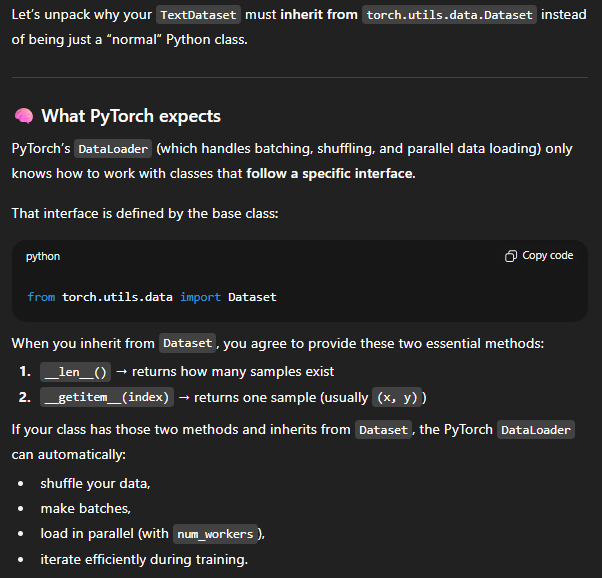
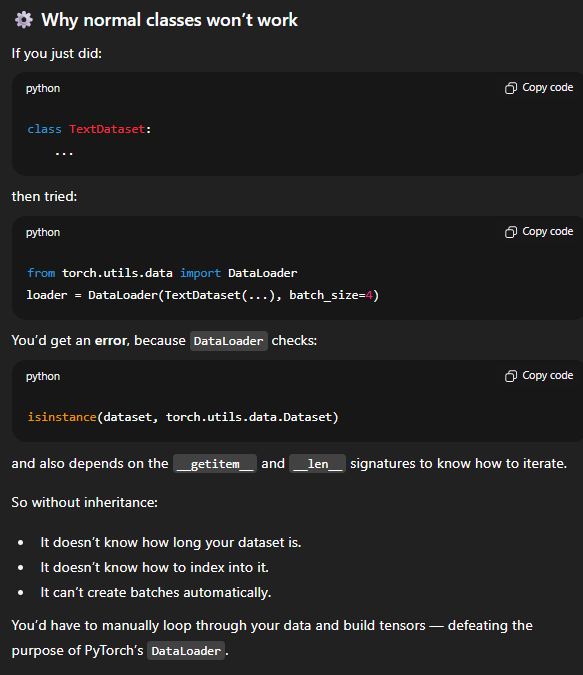
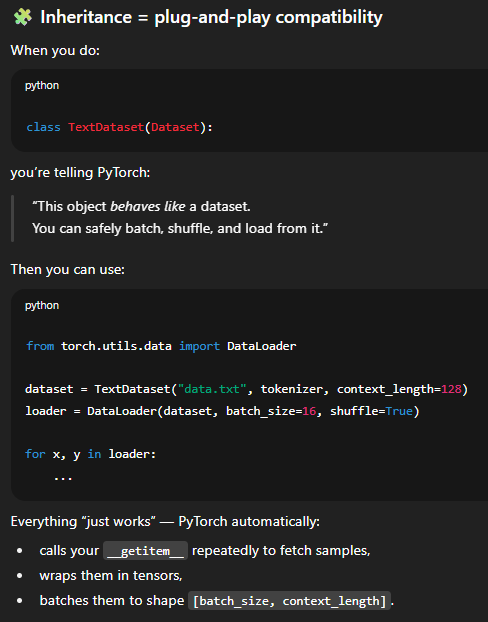
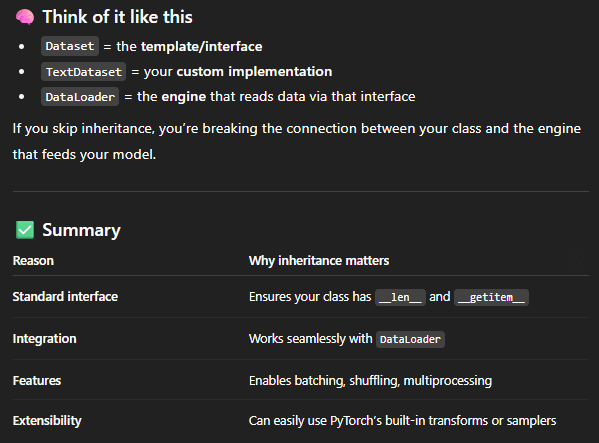

In [16]:
class TextDataset(Dataset):
    def __init__(self, textfile, tokenizer, context_length, max_length=-1):

        # save the context length
        self.context_length = context_length

        # Read the text file
        with open(textfile, 'r', encoding='utf-8') as f:
            raw_data = f.read()

        # Prune the text to maximum length upon request
        if max_length > 0:
            raw_data = raw_data[:max_length]
        
        # Tokenize and encode the text
        encoded = tokenizer.encode(raw_data) # string --> encoding object (contains the ID list of token list)

        # get the input_ids
        self.input_ids = encoded.ids
        
    def __len__(self):
        return len(self.input_ids) - self.context_length - 1 # ensure that the last text block has a length of context length
    
    def __getitem__(self, idx):
        # x = text from (idx, idx+context_length)
        x_batch = torch.tensor(self.input_ids[idx: idx+self.context_length]) # remember to convert to tensor before giving to DataLoader
        
        # y = text from (idx+1, idx+context_length+1)
        y_batch = torch.tensor(self.input_ids[idx+1: idx+self.context_length+1])
        
        return x_batch, y_batch

Create a dataset and dataloader. Get a batch of sample.

In [17]:
dataset    = TextDataset(dataset_path, tokenizer, context_length=64, max_length=500000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
#So you’re training on 32 samples at once (each of length 64 tokens).

x_batch, y_batch = next(iter(dataloader))

print('x_batch.shape =', x_batch.shape)
print('y_batch.shape =', y_batch.shape)

print('\nFirst sample:')
print('x:', x_batch[0, :10])
print('y:', y_batch[0, :10])

x_batch.shape = torch.Size([32, 64])
y_batch.shape = torch.Size([32, 64])

First sample:
x: tensor([   9,  342, 2706,  393, 1351,    9,  124, 1204,  154,  342])
y: tensor([ 342, 2706,  393, 1351,    9,  124, 1204,  154,  342, 1725])


Positional Embedding

---
# Section 4: Language Model Modeling with Transformer

## 4.1 Positional Encoding

First, let's define the positional encoding class.

                                            # Div_term

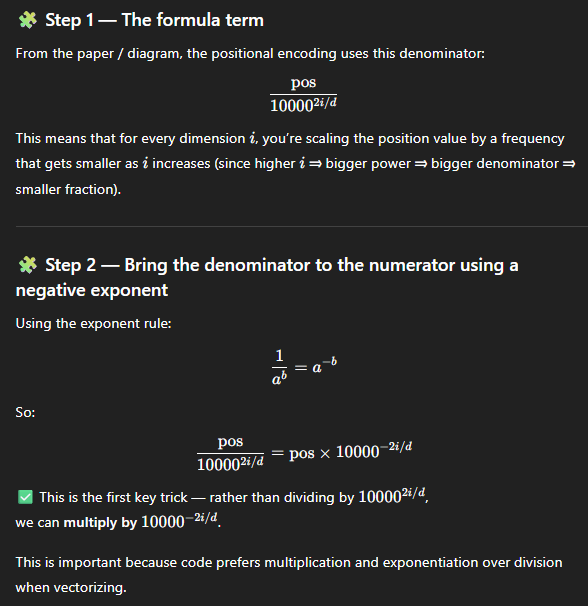
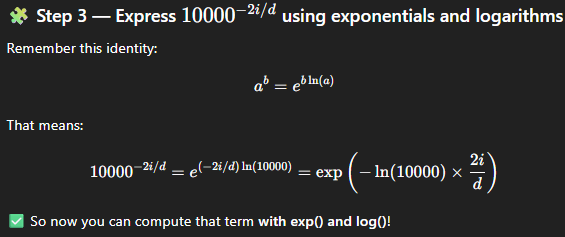
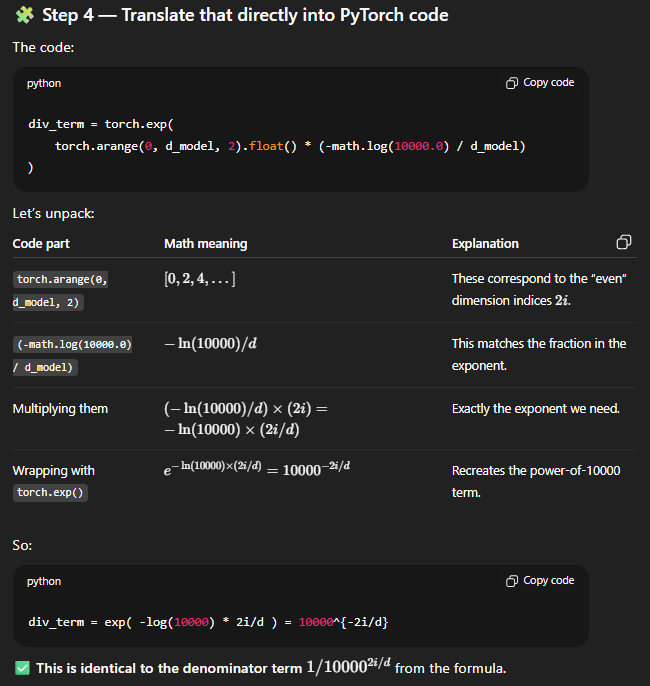
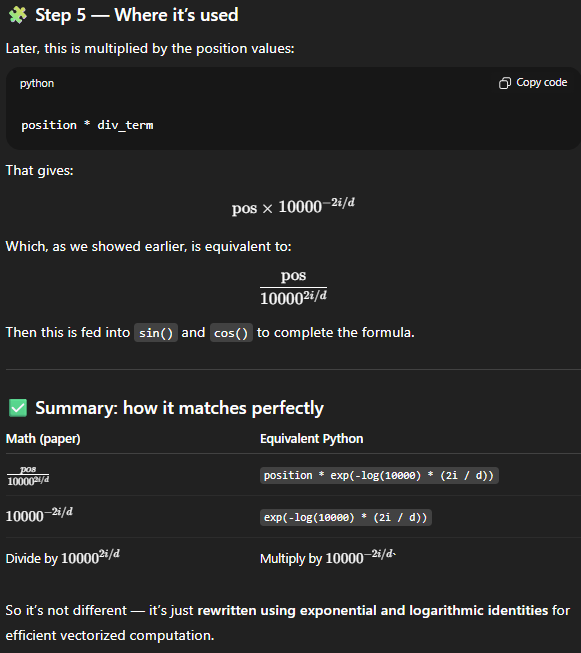

# Better break down of the div_term code

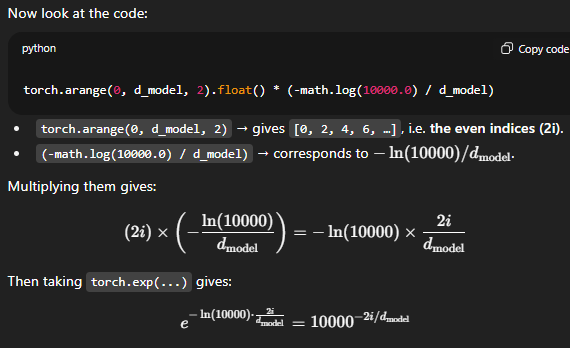

```python
- the term '2i' from the formula is represented as "torch.arange(0, d_model, 2).float()"
- it is multiplied separately, which in the end gives the same result.

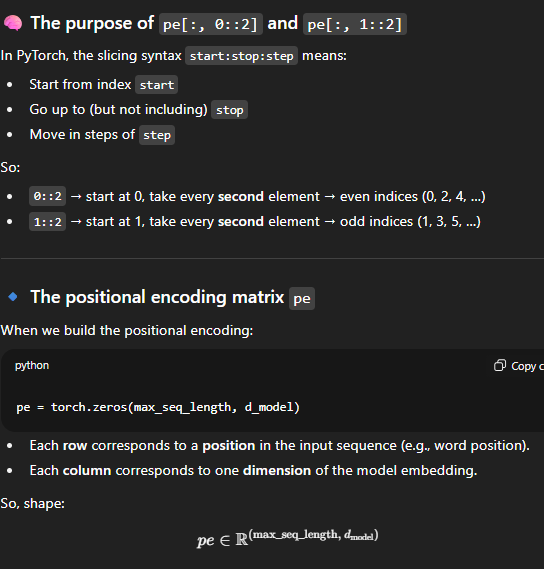
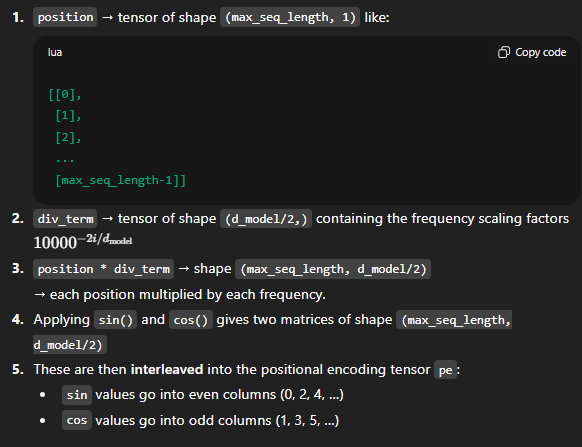

# max_seq_length
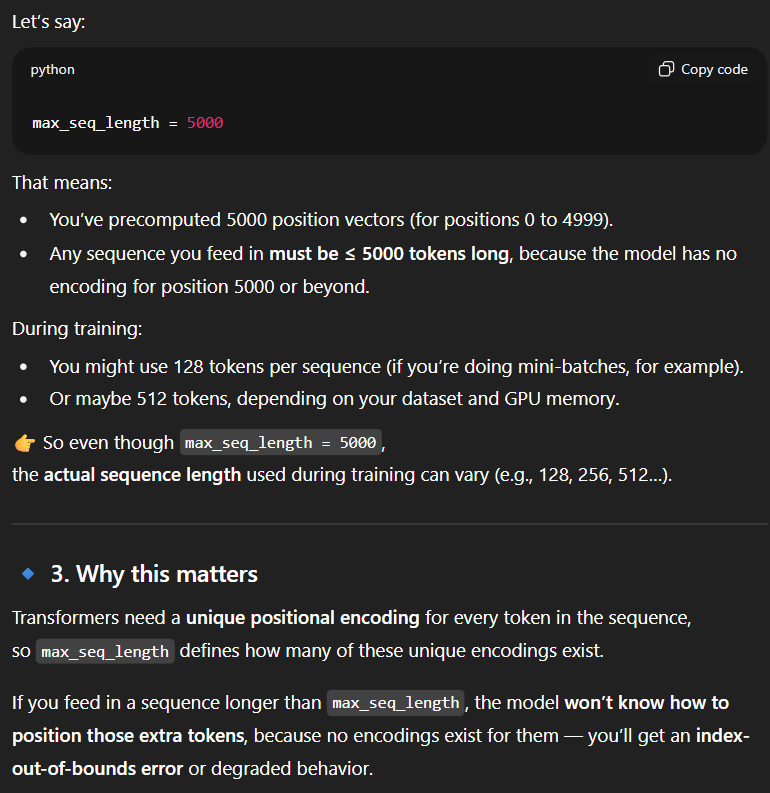

```python
meaning of "return x + self.pe[:, :x.size(1), :]"
```

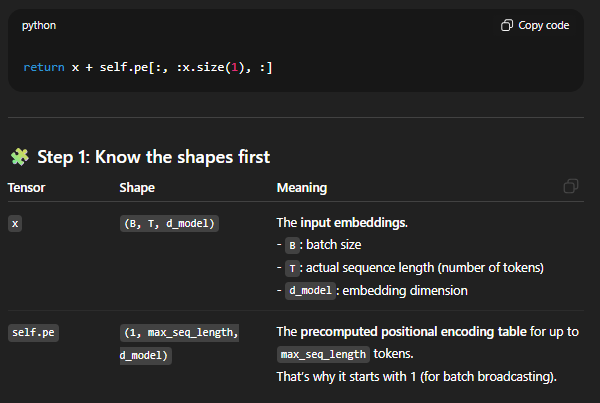
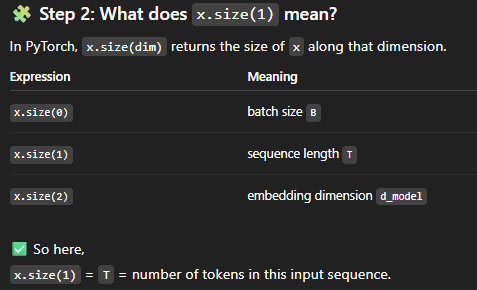
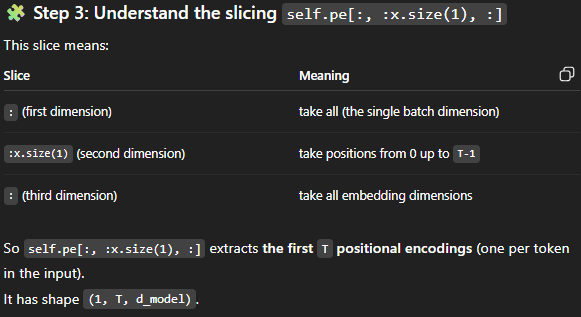
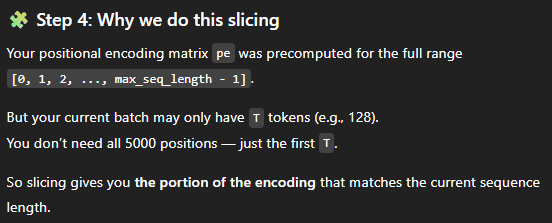
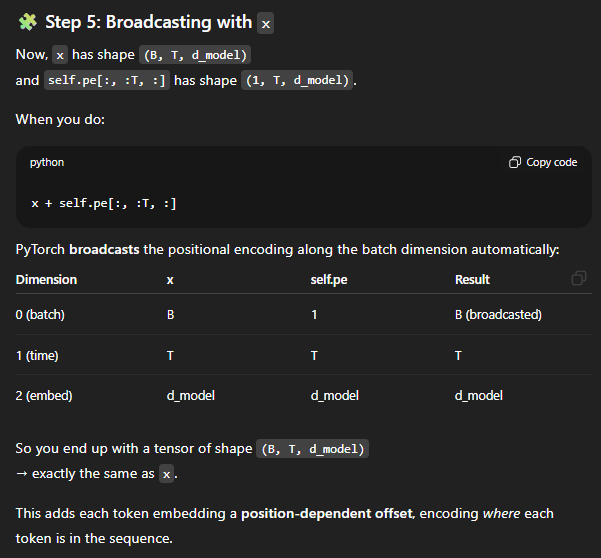
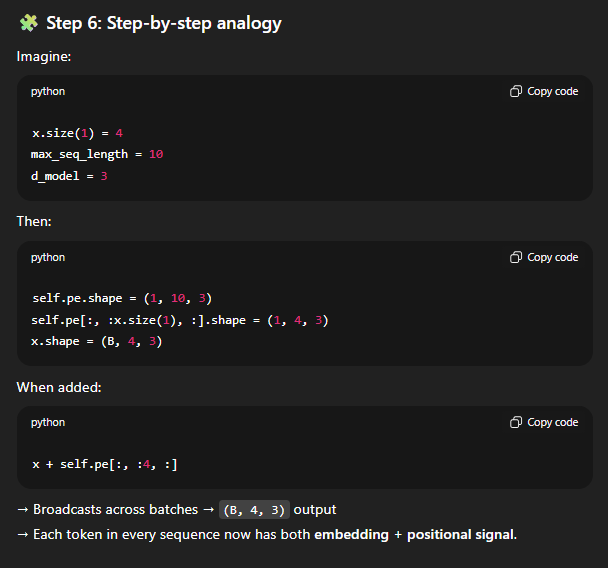
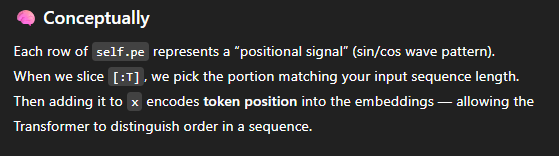

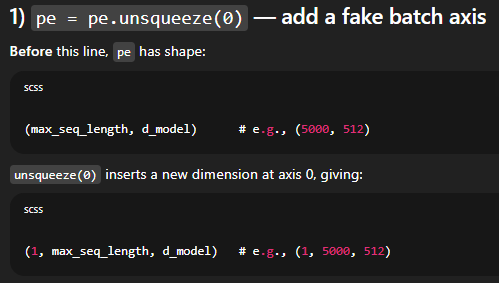
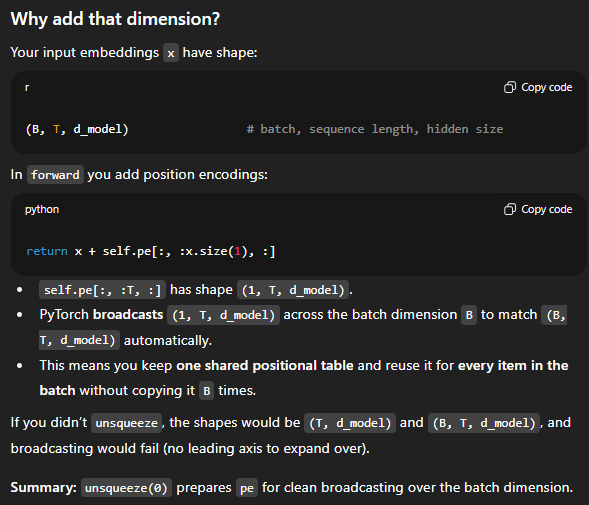
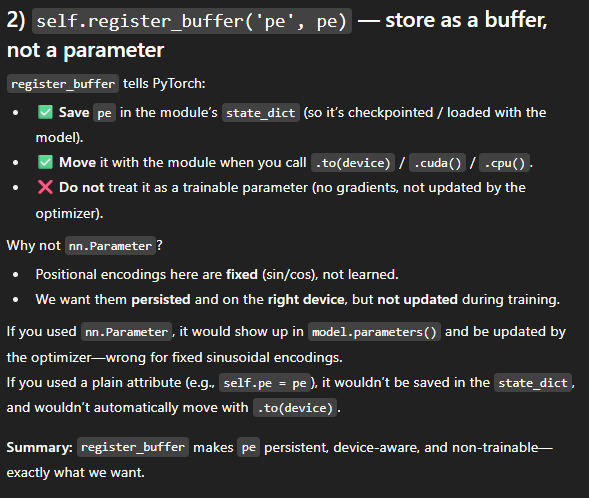

# When to use self and when not to use self when writing Python Classes
- since the PE are not a learnable matrix/parameter hence it does not need to use self

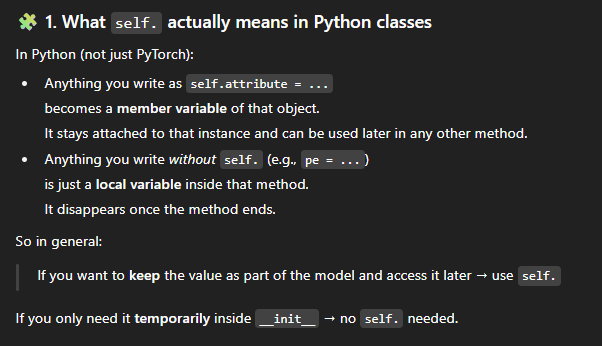
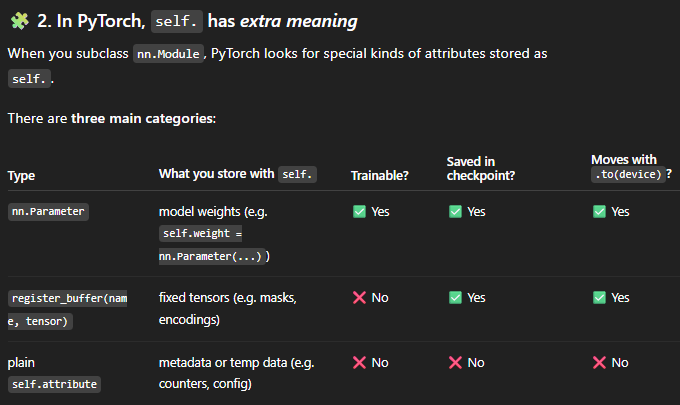
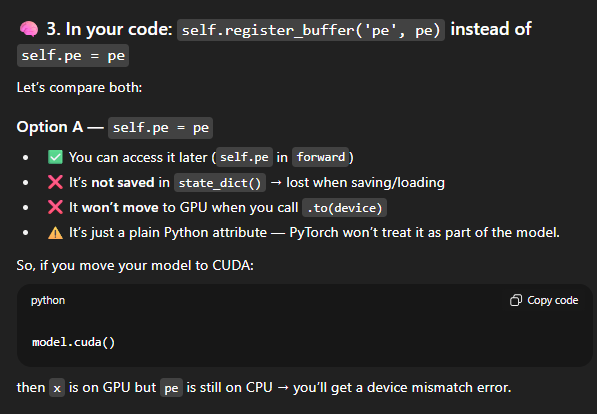
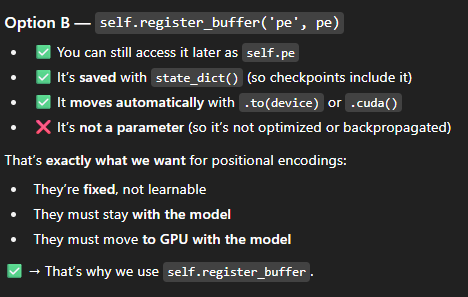
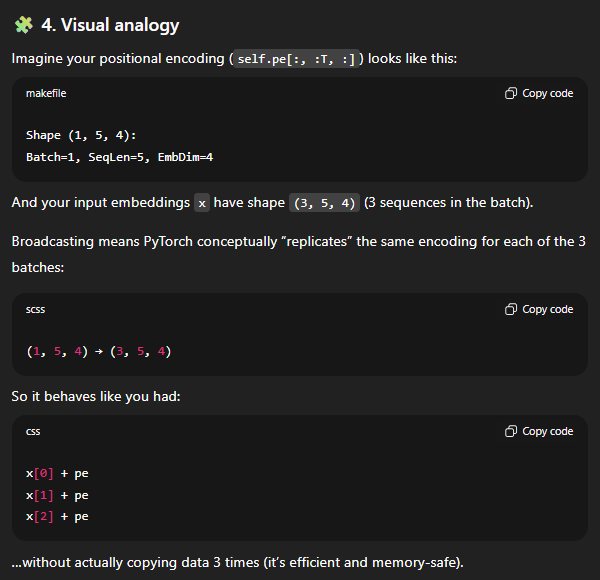

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length, d_model) # just to initialise the PE dimensions in a list
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension
        pe = pe.unsqueeze(0)
        
        # Register buffer (not a parameter, but should be saved & restored in state_dict)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add positional encoding to input embeddings
        return x + self.pe[:, :x.size(1), :] # x.size(1) = T
                                             # Shape of x = (B, T, d_model)
                                             # Shape of self.pe = (1, T_max, d_model) where T_max > T (broadcasting happens when added to x)
                                             # The value of x.size(1) = T. Slicing with :x.size(1) return the position vector for time step 0 to T - 1

## 4.2 Language Modeling with Encoder-Only Transformer

Now, let's build the language model with a Encoder-Only Transformer. The network `LMNet` has the following layers:

|Layer| Configuration | Shape |
|---|---|---|
| Input | - | `(B, T)`|
|Token Embedding | num_embedding = vocab_size, <br> embedding_dim = d_model | `(B, T, d_model)`|
|Position Embedding | d_model = d_model | `(B, T, d_model)`|
|TransformerEncoder | d_model (default: 512), <br> nhead (default = 6), <br> dim_feedforward, <br> batch_first (default: False) | `(B, T, d_model)` |
| fc | in_features = d_model, <br> out_features = vocab_size | `(B, T, vocab_size)` |

PyTorch offers the necessary [transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers) to built the transformer model, including:

1. [nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer) - a tranformer model. The module is constructed from `nn.TranformerEncoder` and `nn.TransformerDecoder` below.
2. [nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) - a stack of *N* encoder layers
3. [nn.TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder) - a stack of *N* decoder layers
4. [nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) - made up of multi-head (self) attention and feedforward network
5. [nn.TransformerDecoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html#torch.nn.TransformerDecoderLayer) - made up of multi-head (self) attention, multi-head (encoder) attention and feedforward network

#### The nn.TransformerEncoder module

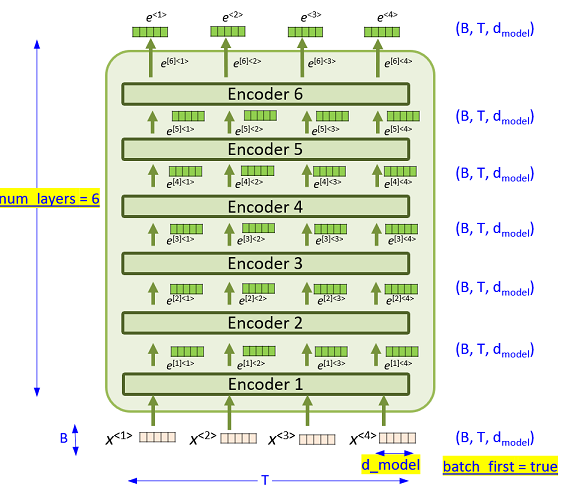

#### The nn.TransformerEncoderLayer module

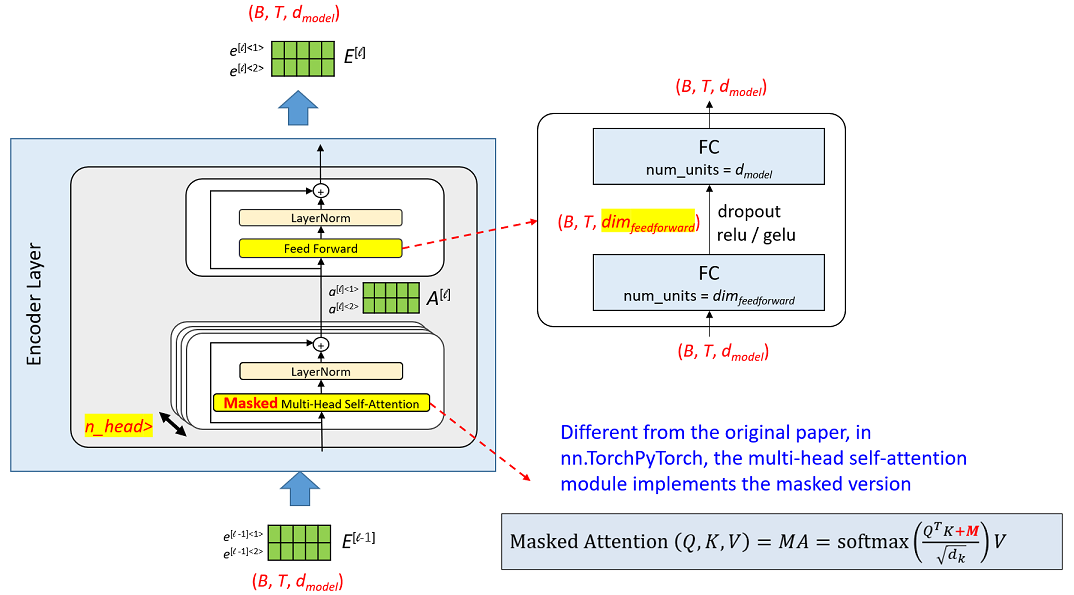

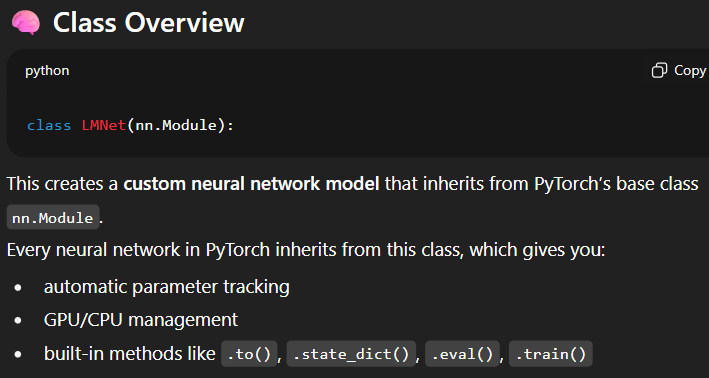
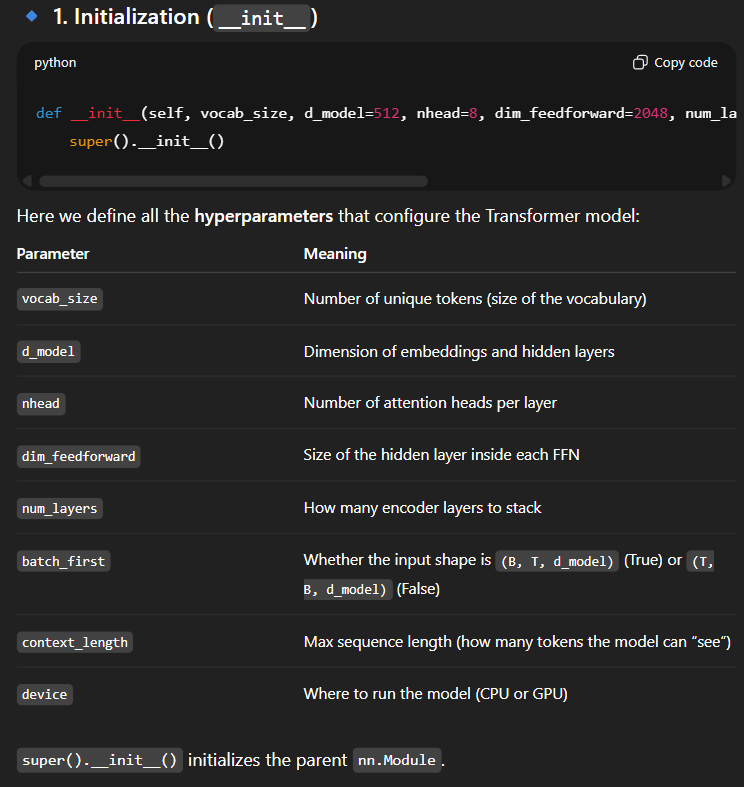
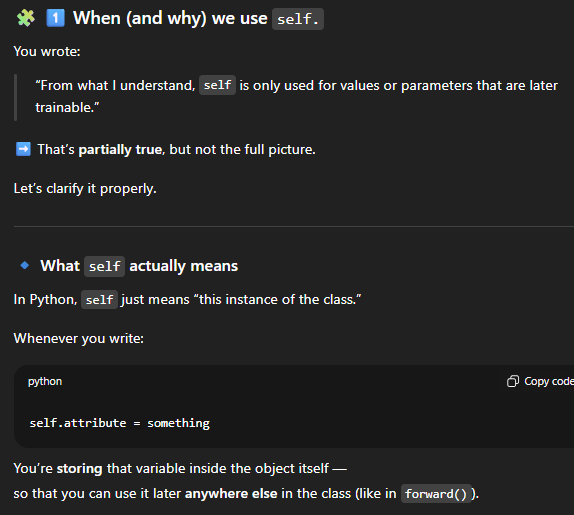
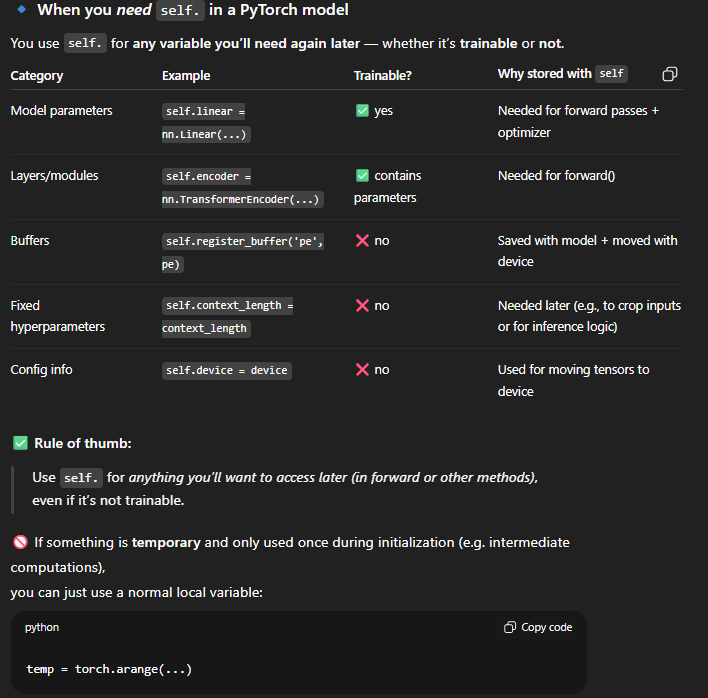
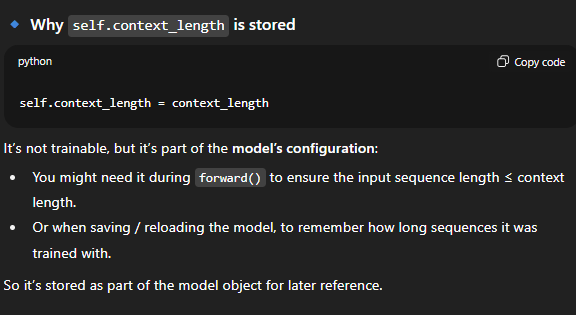
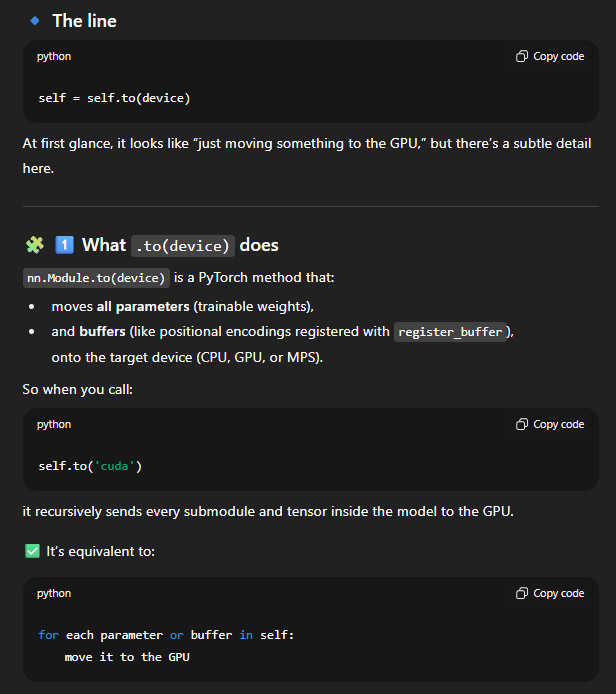
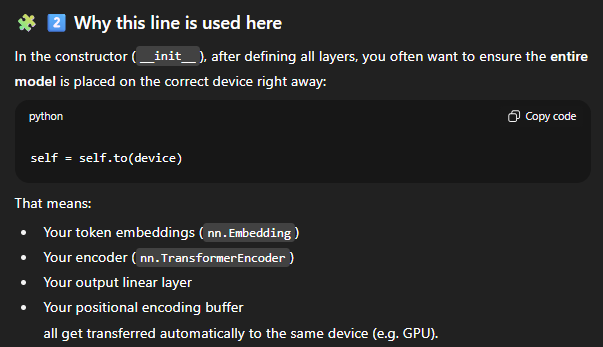
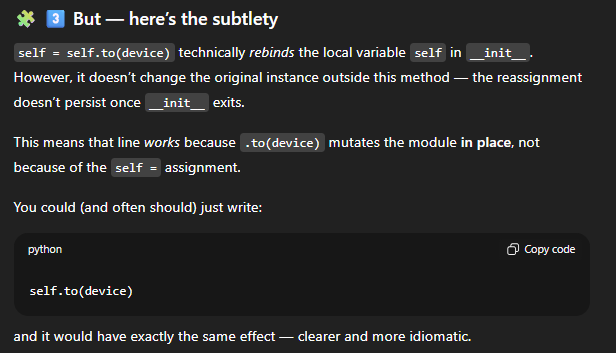

In [24]:
class LMNet(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, dim_feedforward=2048, num_layers=6, batch_first=True, context_length=64, device="cpu"):
        super().__init__()

        # save the context length used during training
        self.context_length = context_length

        # save the device
        self.device = device
        
        # token embedding (convert token IDs into embedding vector)
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
        
        # positional embedding layer (insert position information into each token vector)
        self.pos_encoding = PositionalEncoding(d_model=d_model)

        # create the encoder block
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=batch_first)
        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)

        # create the linear layer
        self.fc      = nn.Linear(in_features=d_model, out_features=vocab_size)

        # transfer to targeted device
        # self         = self.to(device)
        self.to(device)
    

    def forward(self, x, mask = None):

        #print("Input: ", x.shape)
        # convert each token into its embedding vetor
        x = self.token_embedding(x)
        #print("After token embedding: ", x.shape)

        # add position embedding to x
        x = self.pos_encoding(x)
        #print("After position endoding: ", x.shape)

        # perform sequence model inference
        x = self.encoder(x, mask) # added the mask
        #print("After encoder network: ", x.shape)

        # generate logits
        x = self.fc(x)
        #print("After linear layer: ", x.shape)
        

        return x

Test the model without any masking

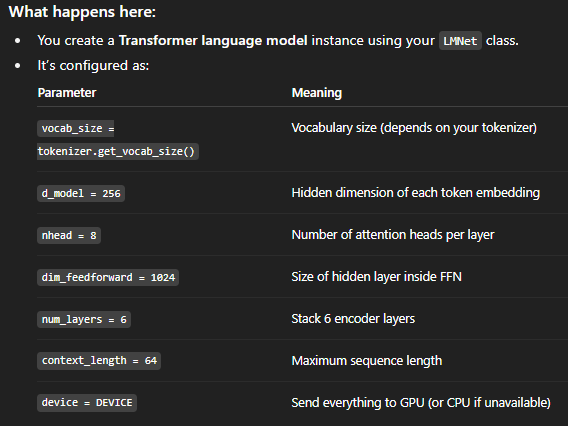
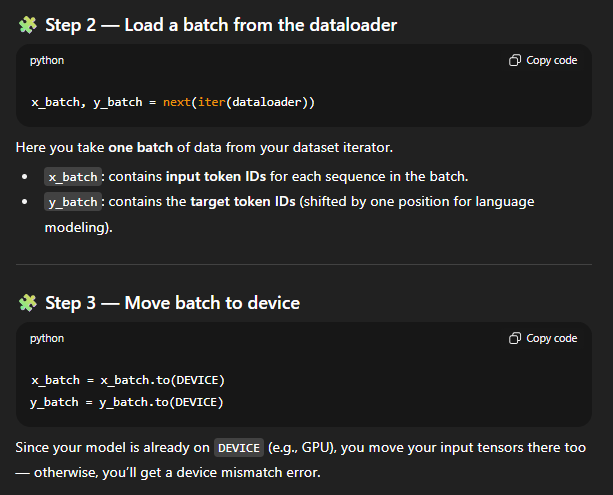
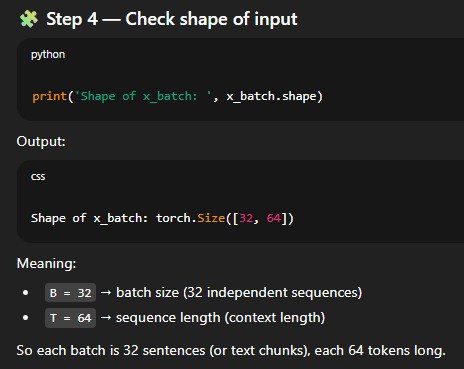
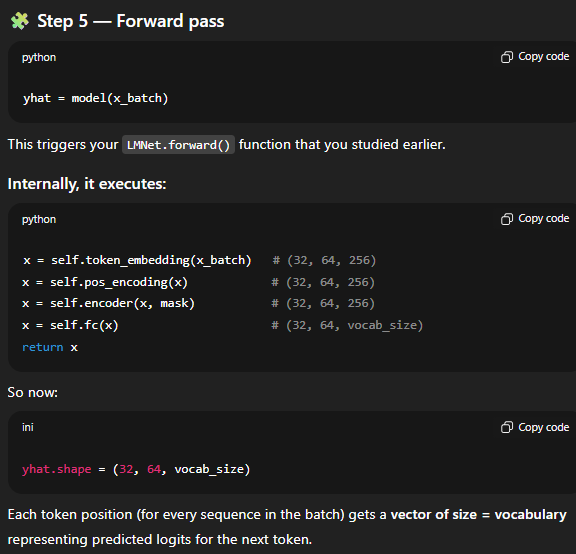
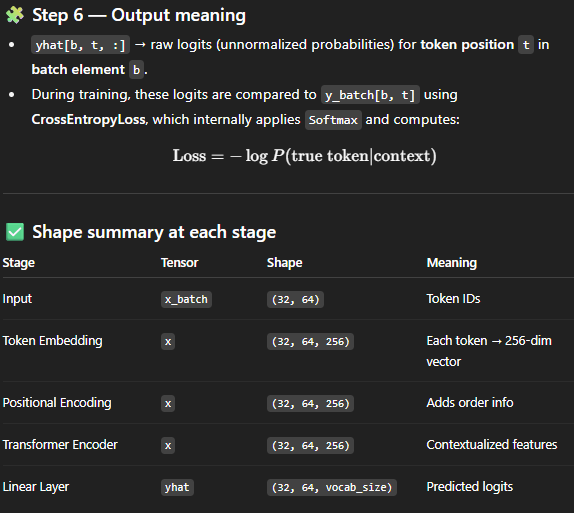

In [25]:
model = LMNet(tokenizer.get_vocab_size(), d_model=256, nhead=8, dim_feedforward=1024, num_layers=6, batch_first=True, context_length=64, device=DEVICE)

In [26]:
x_batch, y_batch = next(iter(dataloader))
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
print('Shape of x_batch: ', x_batch.shape)

Shape of x_batch:  torch.Size([32, 64])


In [27]:
yhat = model(x_batch)

## 4.3 Define the mask

Our model is auto-regressive, i.e., it should only use past and current tokens $\{1, ..., t\}$and ignore future tokens $\{t+1, ..., T_x\}$  when predicting current token. Since our input is a token sequence, we need to enforce the output at all timestep follow this requirement even though we are only interested in the last output token. To do this, we can use a *mask* $M$ to disable future tokens:

$$\mathrm{A_m}(Q, K, V) = \mathrm{softmax}(\frac{Q^TK + M}{\sqrt{d_{model}}})V$$

The mask $M$ is an upper triangular matrix of size $T_x\times T_x$ where the items at the upper left of $M$ has values of $-\infty$. For example, when the sequence length $T_x = 5$, the value of $M$ is given by:

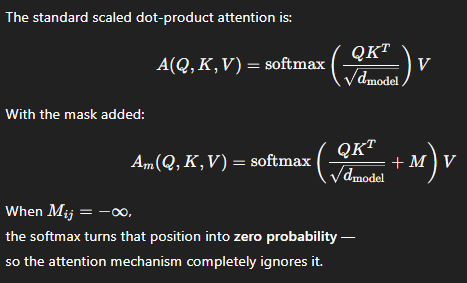
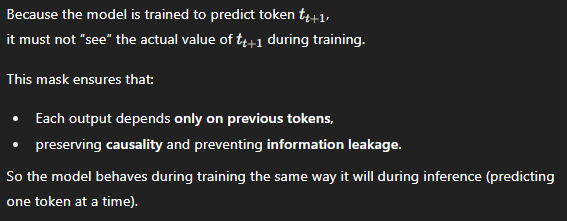
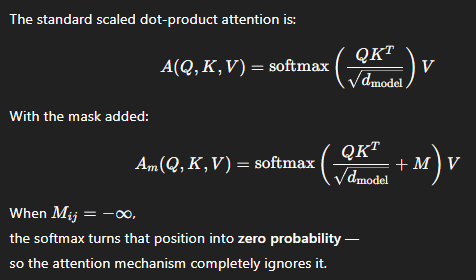

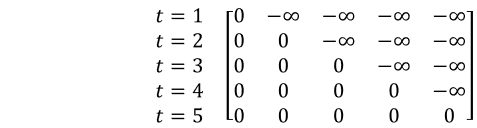

Each row $M[t, :]$ represents the mask used to generate $\hat{y}^{<t>}$, i.e., the output at timestep $t$ where columns (time step) with a value of $0$ will be considered while those with a value of $-\infty$ discarded.
For example, for $t=2$, only tokens from time step $1$, $2$ and $3$ (their values are 0) will be considered. Tokens from timestep $4$ and $5$ will be discarded.

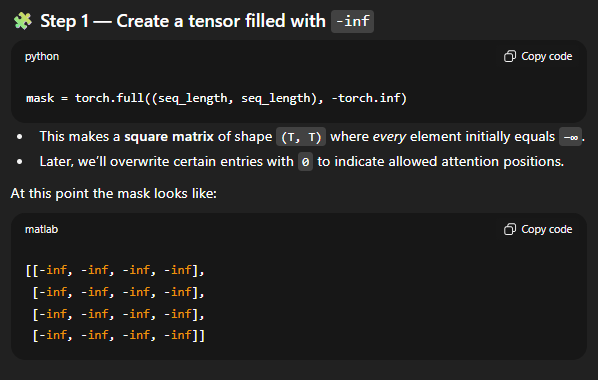
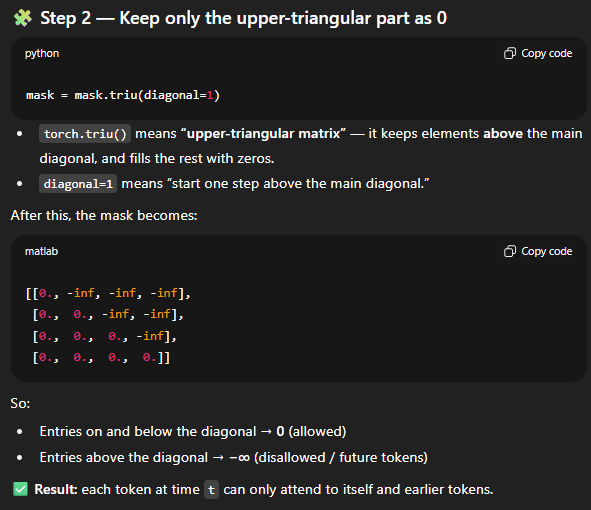

In [28]:
def create_mask(seq_length, device):
    # create a tensor of shape (seq_length, seq_length) with value -inf (use `torch.full`)
    mask = torch.full((seq_length, seq_length), -torch.inf)

    # set the diagonal and lower left part of mask to 0 (use `torch.triu` with `diagonal` set to 1 )
    mask = mask.triu(diagonal=1)

    # transfer to device
    mask = mask.to(device)
    
    return mask

Modify the `forward` function of `LMNet` to pass the generated `mask` to the encoder object.

In [29]:
x_batch, y_batch = next(iter(dataloader))
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)

print('Shape of x_batch:', x_batch.shape)

Shape of x_batch: torch.Size([32, 64])


In [30]:
mask = create_mask(seq_length = x_batch.shape[1], device = DEVICE)
print('Shape of mask:', mask.shape)
print(mask)

Shape of mask: torch.Size([64, 64])
tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [31]:
yhat_batch = model(x_batch, mask)
print('Shape of yhat:', yhat.shape)

Shape of yhat: torch.Size([32, 64, 5000])


## 4.4 Train the Language Model

Settings for training

In [32]:
D_MODEL         = 256
NHEAD           = 8
DIM_FEEDFORWARD = 1024
NUM_LAYERS      = 6
VOCAB_SIZE      = tokenizer.get_vocab_size()
BATCH_FIRST     = True

MAX_ITERS       = 5000
BATCH_SIZE      = 128
MAX_LENGTH      = 500000
CONTEXT_LENGTH  = 64
LR              = 5e-4

Create the model and optimizer

In [33]:
model = LMNet(VOCAB_SIZE, D_MODEL, NHEAD, DIM_FEEDFORWARD, NUM_LAYERS, BATCH_FIRST, CONTEXT_LENGTH, DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

Create the dataset and data loader

In [34]:
dataset = TextDataset(dataset_path, tokenizer, CONTEXT_LENGTH, MAX_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Define the training function

## Code Explanation
```python
yhat_batch = model(x_batch, mask) # x: (B, T), yhat_batch: (B, T, vocab_size)
```

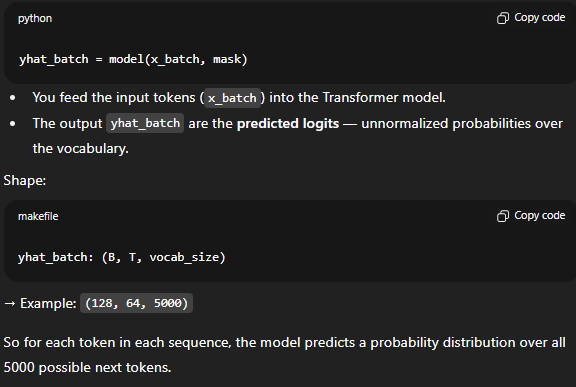
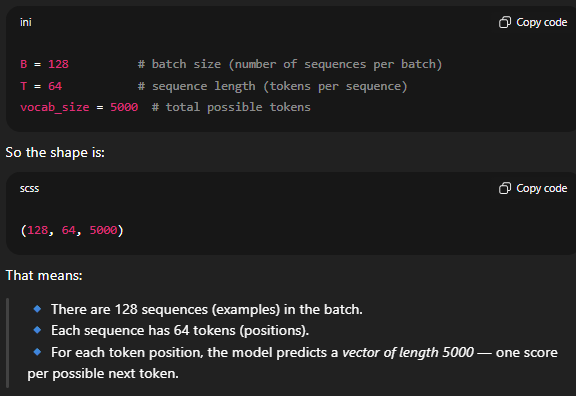
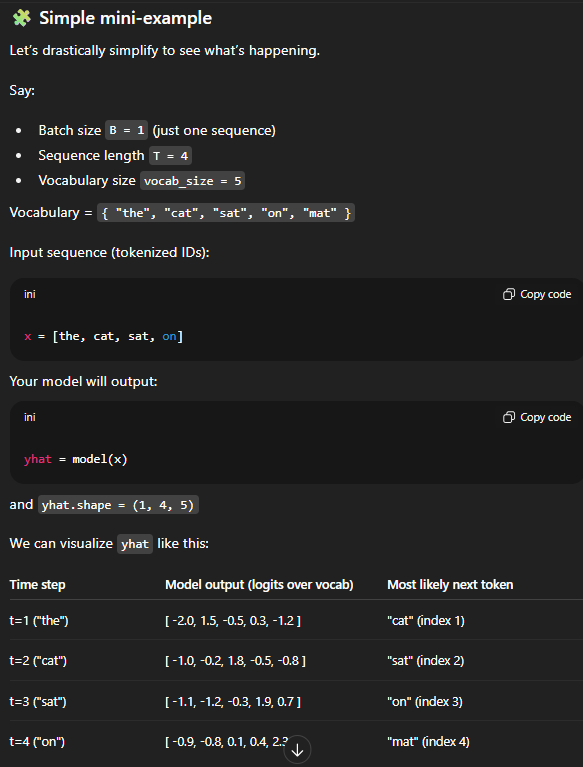
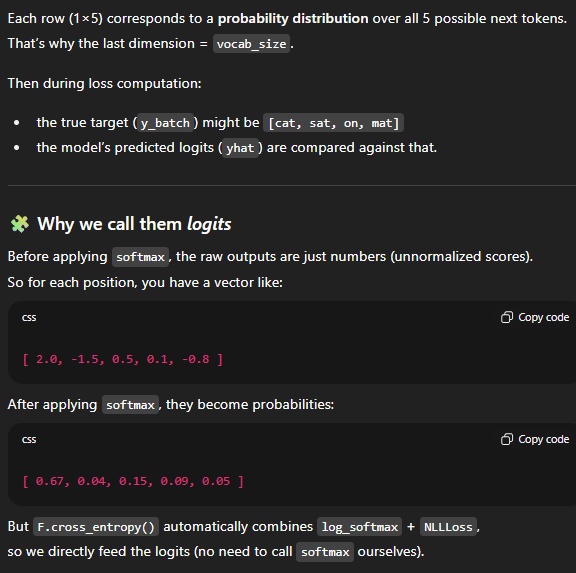
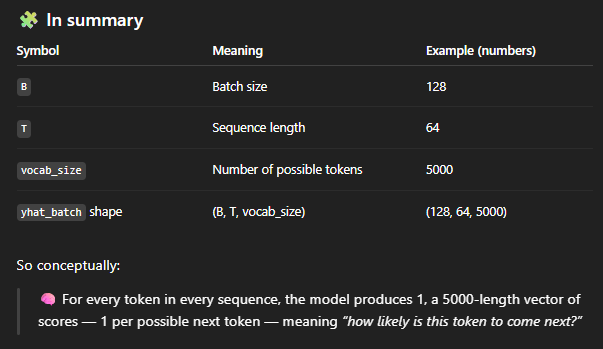

```python
yhat_batch = yhat_batch.view(B*T, C) # (B, T, vocab_size) --> (B*T, vocab_size) This is because F.cross_entropy canonly handle 2 dimensions
y_batch = y_batch.view(B*T) # (B, T, vocab_size) --> (B*T, vocab_size)
loss = F.cross_entropy(yhat_batch, y_batch)
```
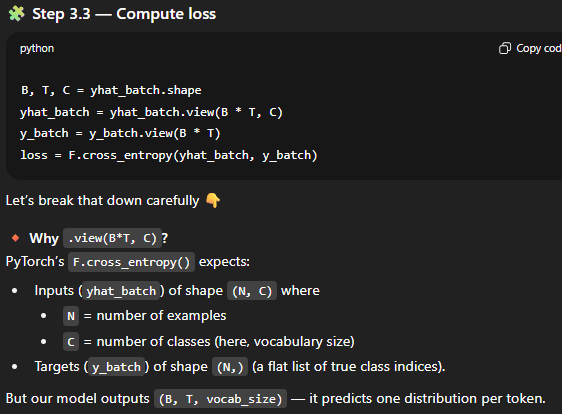
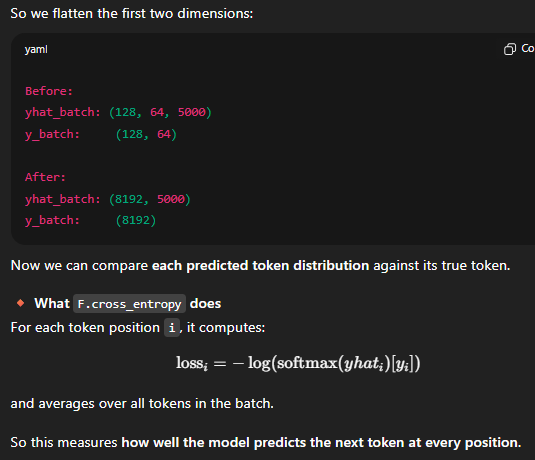

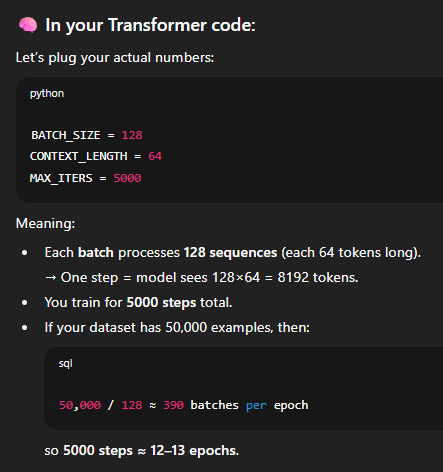

In [35]:
def train(model, optimizer, batch_size, max_iters, device):

    # set to traiing mode
    model.train()

    # for transformer, a mask is required
    mask = create_mask(model.context_length, device)

    # train until convergence
    for steps in range(max_iters):

        # sample a batch of data
        x_batch, y_batch = next(iter(dataloader))
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # forward propagation
        yhat_batch = model(x_batch, mask) # x: (B, T), yhat_batch: (B, T, vocab_size)

        # compute loss
        B, T, C = yhat_batch.shape
        yhat_batch = yhat_batch.view(B*T, C) # (B, T, vocab_size) --> (B*T, vocab_size) This is because F.cross_entropy canonly handle 2 dimensions
        y_batch = y_batch.view(B*T) # (B, T, vocab_size) --> (B*T, vocab_size)
        loss = F.cross_entropy(yhat_batch, y_batch)

        # backpropagation
        loss.backward()
        optimizer.step()

        # reset the optimizer
        optimizer.zero_grad()

        # print the training loss
        if (steps+1) % 200 == 0 or (steps+1)%max_iters == 0 or steps == 0:
            print(f"Iter {steps+1}: train loss {loss:.4f}")

Train the model

In [36]:
train(model, optimizer, BATCH_SIZE, MAX_ITERS, DEVICE)

Iter 1: train loss 8.6740
Iter 200: train loss 4.4763
Iter 400: train loss 3.4318
Iter 600: train loss 2.6082
Iter 800: train loss 1.9221
Iter 1000: train loss 1.3965
Iter 1200: train loss 0.9661
Iter 1400: train loss 0.7159
Iter 1600: train loss 0.6211
Iter 1800: train loss 0.5375
Iter 2000: train loss 0.4672
Iter 2200: train loss 0.4318
Iter 2400: train loss 0.4134
Iter 2600: train loss 0.3842
Iter 2800: train loss 0.3583
Iter 3000: train loss 0.3470
Iter 3200: train loss 0.3382
Iter 3400: train loss 0.3287
Iter 3600: train loss 0.3100
Iter 3800: train loss 0.2931
Iter 4000: train loss 0.2847
Iter 4200: train loss 0.2819
Iter 4400: train loss 0.2867
Iter 4600: train loss 0.2724
Iter 4800: train loss 0.2703
Iter 5000: train loss 0.2689


## 4.5 Generating novel text

To generate novel text, we implement the method `generate`. Since the network is trained on a sequence of length `T` = `block_size`, when generating the text, we feed the most recent `block_size` characters into the network to generate the next character. Here are the steps:

1. Crop the most recent `block_size` characters in the generated text
2. The cropped text is fed to the generative model to generate the next character. The network output the `logit` value.
3. Convert the logit of the network to `probit` value by performing `softmax` operation.
4. Sample a character from the `probit` by using [`torch.multinorm`](https://pytorch.org/docs/stable/generated/torch.multinomial.html)
5. Append the sampled character to the end of the generated text.
6. Repeat steps 1-5 for `text_len` times

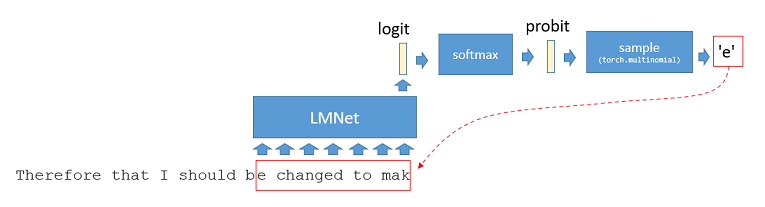

In [37]:
def generate(model, title, text_len, device):

    # Generate the title following the format in the training set
    title += (".\n\n")
    print(title)

    # set to evaluation mode
    model.eval()
    
    # initialize token to with one zero token (newline). Size of text = (B, T) = (1 sentence, 1 token)
    text = torch.tensor(tokenizer.encode(title).ids, dtype=torch.long).reshape(1, -1).to(device)
    
    # repeat until the length of text = "text_len"
    for _ in range(text_len):  # (B, T)
    
        # crop text to the last context length tokens
        text_cond = text[:, -model.context_length:] # only consider the recent text, maximum sequence length is limited by context length
    
        # get the predictions
        mask    = create_mask(text_cond.shape[-1], device)
    
        # disable gradient computation
        with torch.inference_mode():
    
            # predict next token
            logit = model(text_cond)         # logits: (B, T, F)
    
            # focus only on the last time step
            logit_n = logit[:, -1, :]           # logit_n: (B, vocab_size), -1 = select last time_step
    
            # apply soft max to get probabilities
            probit_n = F.softmax(logit_n, dim=-1)  # probit_n: (B, F)
    
            # sample from distribution
            next_token = torch.multinomial(probit_n, num_samples=1)  # next_token: (B, 1)
    
            # append sampled index to the running sequence
            text = torch.cat((text, next_token), dim=0) # (B, T+1)
    
            # print the sample
            print(tokenizer.decode([next_token.item()]), end='')

            # generate some delay
            time.sleep(0.01)

In [42]:
def generate(model, title, text_len, device):

    # Generate the title following the format in the training set
    title += (".\n\n")
    print(title)

    # set to evaluation mode
    model.eval()
    
    # initialize token to with one zero token (newline). Size of text = (B, T) = (1 sentence, 1 token)
    text = torch.tensor(tokenizer.encode(title).ids, dtype=torch.long).reshape(1, -1).to(device)  # (B, T) = (1, T)
    
    # repeat until the length of text = "text_len"
    for _ in range(text_len):  # (B, T)
    
        # crop text to the last context length tokens
        text_cond = text[:,-model.context_length:]  # only consider the recent text, maximum sequence length is limited by the context length
    
        # get the predictions
        # mask    = create_mask(text_cond.shape[-1], device)
    
        # disable gradient computation
        with torch.inference_mode():
    
            # predict next token
            logit = model(text_cond)              # logits: (B, T, vocab_size)
    
            # focus only on the last time step
            logit_n = logit[:, -1, :]              # logit_n: (B, vocab_size)
    
            # apply soft max to get probabilities
            probit_n = F.softmax(logit_n, dim=-1)  # probit_n: (B, vocab_size)
    
            # sample from distribution
            next_token = torch.multinomial(probit_n, num_samples=1) # next_token: (B, 1)
    
            # append sampled index to the running sequence
            text = torch.cat((text, next_token), dim=-1) # (B, T+1)
    
            # print the sample
            print(tokenizer.decode([next_token.item()]), end='')

            # generate some delay
            time.sleep(0.01)

Generate novel content with the model

In [44]:
generate(model, title="How old is the Tree?", text_len=500, device=DEVICE)

How old is the Tree?.


Every good will it say TH’m, there you have always beautiful jewels in such a dream. If you will surely her with you shall be exterminated.”
The King was at being now set to help him, delighted at once to help the hospital; but as soon as it was only Princess! Under this certainly was to marry the way; and once a real bird faded the little pot of the castle which lay east of the sun and west of the moon, and that now she was to marry the same species.
And then the marriage was celebrated. Six earth-worms shone as well as they could. In other respects the whole went off very quietly, for the old folks could not bear noise and merriment; but old Dame Snail made a single word of Karen purse full of jewels.
“IGive me a red rose,” she cried, “and I will sing you my sweetheart. I have a simpleton! I have never have never thought of speaking to undressed! But I have seen her a single word of him, but for it was the little Kay!
The Prince was lastately dictating his mem

In [46]:
model2 = LMNet(VOCAB_SIZE, D_MODEL, NHEAD, DIM_FEEDFORWARD, NUM_LAYERS, BATCH_FIRST, CONTEXT_LENGTH, DEVICE)
generate(model2, title="The Magic Tree.", text_len=500, device=DEVICE)

The Magic Tree..


 suc dragifully considerable shot hidden cook snail Ev eaten kill carriedHA sakeepIn Marchupon listening warmis stories espe Sim key poundsc un Jenningsalt arrival influho upstairsmp meal mess parents skin Christmas keenember thro Georgeasia hunrily Pav dry triedutes contin'mealizabetha common beastorig depading feelings gentlemen killood storleas walls dailt conclWe meat imagennings year distress bringrench� world asbit awoke bill Can rushed Prossvers case ill Al uncle generalcil England fewading legthing coast never holl sever midst fled fountainifullyix stuffade Ts Cartonogo quitemnred driven busy Pav except steppedorrow sight hear companynONient hunt purple spe stands particere.” charming pushed pine assag leaves cal ladyust single peculiarague whe:cobellStvere� passage gri fountainappy Barument at tight memory guess l Cra lonelyisedsoir| quite wood necessaryicesward shock't forever puricotted equally Come wid dispry safboard ride lossuponuttering fledrowiseod ga

<center> --- END OF LAB --- </center>